### Iterative Workflow

- So here we are trying to generate a post for X or linkedin 
- Steps - Topic given to LLM -> Generate Post -> Evaluate Post -> Optimize 
- Optimize and evaluation will happen until the post meets standard (provided to LLM by the user)


In [6]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [7]:
# Here we need to have three steps - generate post, evaluate post, optimize post
# so we need to employ three llms

load_dotenv()

generator_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
evaluator_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
optimizer_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [8]:
# create a structured schema to get evaluations

class EvaluationSchema(BaseModel):
    evaluation: Literal['approved', 'needs_improvement'] = Field(description='Evaluation of the tweet needs to be performed')
    feedback: str = Field(description='Feedback needs to be provided')

structured_evaluation_llm = evaluator_llm.with_structured_output(EvaluationSchema)


In [9]:
# Tweet State creation

class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal['approved', 'needs_improvement']
    feedback: str
    iteration: int
    max_iterations: int

In [19]:
def generate_tweet(state: TweetState):


    # - This is version {state['iteration'] + 1}.

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
            Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
            Rules:
                - Do NOT use question-answer format.
                - Max 280 characters.
                - Use observational humor, irony, sarcasm, or cultural references.
                - Think in meme logic, punchlines, or relatable takes.
                - Use simple, day to day english.
        """)
    ]

    # send prompt to llm
    response = generator_llm.invoke(messages).content

    # update state and return
    return {'tweet': response}

In [20]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a ruthless no-laugh-given twitter critic. You evaluate tweets based on virality, humor, orignality, and tweet format."),
        HumanMessage(content=f"""
            Evaluate the following tweet: \n\n Tweet: {state['tweet']}

            \n\n Criteria to be evaluated on::
                - Originality: Is this tweet original, have you ever seen it before?
                - Humor: Did this tweet really make you laugh or smile or chuckle?
                - Punchiness: Is it short, shary, punchy and scroll stopping?
                - Virality Potential: Will this tweet go viral? Will it get retweeted?
                - Format: Is it a well formed tweet? (Not a setup-puchline joke, not a question-answer format joke, and under 280 characters)
            \n\n Rules for auto rejection:
                - Do NOT use question-answer format.
                - Do NOT exceed 280 characters.
                - If it reads like a treditional setup-punchline joke.
                - Do NOT end with generic, throwaway, or deflating lines, that weaken the humor.

            # Reply with:
            - evaluation: 'approved' or 'needs_improvement'
            - feedback: one paragraph explaination of strengths and weaknesses

            """)       
    ]

    # send prompt to llm
    response = structured_evaluation_llm.invoke(messages)

    # update state and return
    return {'evaluation': response.evaluation, 'feedback': response.feedback}

In [21]:
def optimize_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a Twitter influencer. You optimize tweets based on virality, humor, orignality, and tweet format."),
        HumanMessage(content=f"""
            Optimize the following tweet based on the following feedback:
            \n\n Feedback: {state['feedback']}
            \n\n Orig Tweet: {state['tweet']}

            Rewrite the tweet, and it should be short, viral worthy, and funny. Avoid question-answer format. Do NOT exceed 280 characters.
        """)
    ]

    # send prompt to llm
    response = optimizer_llm.invoke(messages).content

    # update state and return
    return {'tweet': response, 'iteration': state['iteration'] + 1}

In [22]:
def route_evaluation(state: TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
        return 'approved'
    else:
        return 'needs_improvement'

In [23]:
# create the graph
graph = StateGraph(TweetState)

# add nodes to the graph
graph.add_node('generate_tweet', generate_tweet)
graph.add_node('evaluate_tweet', evaluate_tweet)
graph.add_node('optimize_tweet', optimize_tweet)

# add edges to the graph
graph.add_edge(START, 'generate_tweet')
graph.add_edge('generate_tweet', 'evaluate_tweet')
graph.add_conditional_edges('evaluate_tweet', route_evaluation, {'approved': END, 'needs_improvement': 'optimize_tweet'})
graph.add_edge('optimize_tweet', 'evaluate_tweet')

# compile the graph
workflow = graph.compile()

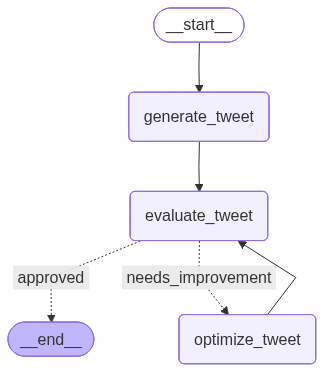

In [24]:
workflow

In [26]:
initial_state = {
    'topic': 'Indian Railways',
    'iteration': 1,
    'max_iterations': 5
}

# run the graph
final_state = workflow.invoke(initial_state)
print(final_state)

{'topic': 'Indian Railways', 'tweet': 'Indian Railways: where every journey is a game of musical chairs—except the music is chai being spilled and the chairs are all reserved! 🎶☕️ Just when you think you’ve found a seat, it’s “Sorry, bhai, that’s my mom’s spot!” 🚂😂 #IndianRailways #TravelStruggles', 'evaluation': 'approved', 'feedback': "This tweet is a clever and original take on the chaotic experience of traveling with Indian Railways, using the metaphor of musical chairs to highlight the struggle for seating. The humor is relatable, especially for those familiar with the situation, and the use of emojis adds a playful touch. The format is well-structured, staying within the character limit and avoiding traditional joke setups. Its punchiness and vivid imagery make it scroll-stopping, increasing its potential for virality. Overall, it's a strong tweet that effectively captures the essence of travel struggles.", 'iteration': 2, 'max_iterations': 5}
